In [1]:
# General use
import re
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
import uuid

# News-handling utilities
import newspaper
from bs4 import BeautifulSoup
import requests
from lib.utils.url_parsers import extract_host, extract_headline, extract_article_artifacts

# Notebook behavior
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
seed = 19  # Replicability

In [2]:
# Load data
df = pd.read_csv("../data/bq-results-20240316-113951-1710589244204.csv", dtype={"GLOBALEVENTID":str, "MentionIdentifier":str, "QuadClass":str, "CAMEOEventRoot":str, "CAMEOEventBase":str, "CAMEOEvent":str})
df = pd.DataFrame({"uuid":[uuid.uuid4() for _ in range(len(df))]}).merge(df, left_index=True, right_index=True).set_index("uuid", drop=True)
df.shape
df.head()

(1018675, 35)

,GLOBALEVENTID,SQLDATE,FractionDate,EventTimeDate,QuadClass,CAMEOEventRoot,CAMEOEventBase,CAMEOEvent,GoldsteinScore,Actor1Code,...,MentionIdentifier,IsRootEvent,SentenceID,Actor1CharOffset,Actor2CharOffset,ActionCharOffset,InRawText,Confidence,MentionDocLen,MentionDocTone
uuid,,,,,,,,,,,,,,,,,,,,,
4687026f-dbbd-4dc0-b261-747048dd3249,1164103006,20240316,2024.2082,20240316081500,1,01,013,013,0.4,MYS,...,https://www.rappler.com/life-and-style/food-dr...,1,3,1169,1210,1180,0,10,7331,3.430962
48b5dce5-1649-4e62-97a6-7ad0ed665118,1164102494,20240316,2024.2082,20240316081500,1,05,051,051,3.4,AFR,...,https://www.sunstar.com.ph/cebu/maximum-mindse...,1,3,1518,1621,1527,0,20,5466,2.898551
a1c3611b-b89d-4f63-b972-09718c98d915,1164060456,20240316,2024.2082,20240316004500,1,01,014,014,0.0,JUDJUD,...,https://mb.com.ph/2024/3/16/new-york-judge-del...,0,8,2479,2527,2513,1,20,2959,-7.831325
911a8e16-a1d4-41e0-85c3-f8375d803158,1164063019,20240316,2024.2082,20240316010000,1,04,043,043,2.8,USA,...,https://mb.com.ph/2024/3/16/biden-praises-us-s...,0,21,3472,3424,3459,0,20,3662,-0.978793
e0ef6c07-6a96-4a52-b873-10e13428948c,1164052553,20240316,2024.2082,20240316000000,4,19,190,190,-10.0,RUSGOV,...,https://globalnation.inquirer.net/228364/putin...,1,2,459,567,553,0,20,5240,-4.127358


In [3]:
# Read docs
docs = pd.read_parquet("cleaned_docs.parquet")
docs.shape
docs.head()

(69960, 11)

,DocOutlet,DocAuthors,DocAuthorsLst,DocAuthorsLen,DocPubDate,DocPubDateNorm,DocHeadline,DocText,DocKeywords,DocKeywordsLst,DocKeywordsLen
https://mb.com.ph/2024/3/1/ikea-philippines-reduces-prices-on-more-than-400-products-starting-march-1,MB,None,[],0,2024-03-01 00:00:00,2024-03-01,IKEA PHILIPPINES REDUCES PRICES ON MORE THAN 4...,Offering quality home furnishings at affordabl...,"['better', 'quality', 'ikea', 'starting', 'p25...","[BETTER, QUALITY, IKEA, STARTING, P250, 400, L...",13
https://mb.com.ph/2024/2/6/always-ayala-letter-to-our-fellow-filipinos,MB,None,[],0,2024-02-06 00:00:00,2024-02-06,ALWAYS AYALA LETTER TO OUR FELLOW FILIPINOS,"Ayala Corporation, the most enduring conglomer...","['190th', 'ayala', 'tribute', 'traces', 'filip...","[190TH, AYALA, TRIBUTE, TRACES, FILIPINOS, TOW...",13
https://mb.com.ph/2024/3/16/p5-m-marijuana-destroyed-in-kalinga,MB,None,[],0,2024-03-16 00:00:00,2024-03-16,P5 M MARIJUANA DESTROYED IN KALINGA,"TABUK CITY, Kalinga – Police destroyed 25,250 ...","['marijuana', 'successful', 'totaling', 'baran...","[MARIJUANA, SUCCESSFUL, TOTALING, BARANGAYS, W...",13
https://mb.com.ph/2024/3/16/2-communist-rebels-surrender-in-cordillera,MB,None,[],0,2024-03-16 00:00:00,2024-03-16,2 COMMUNIST REBELS SURRENDER IN CORDILLERA,"CAMP DANGWA, Benguet – Two New People’s Army r...","['conflict', 'force', 'rebels', 'mountain', 'p...","[CONFLICT, FORCE, REBELS, MOUNTAIN, PROGRAM, S...",13
https://www.sunstar.com.ph/davao/origin-of-davao-city-streets-name,SUNSTAR,['Ralph Lawrence G. Llemit'],[RALPH LAWRENCE G. LLEMIT],1,None,NaT,ORIGIN OF DAVAO CITY STREETS NAME,Ponciano Reyes Street\n\nBefore it was renamed...,"['named', 'gil', 'politics', 'origin', 'munici...","[NAMED, GIL, POLITICS, ORIGIN, MUNICIPAL, PALM...",13


In [4]:
# Check for duplicate events
# Initial assumption: GLOBALEVENTID should be unique
df["GLOBALEVENTID"].value_counts()

GLOBALEVENTID
1107249361    108
1117127091    107
1104348816    106
1123935022    105
1108674312    103
             ... 
1144351724      1
1144352056      1
1144467827      1
1144466414      1
1106595081      1
Name: count, Length: 883292, dtype: int64

In [5]:
# Check where duplicates are coming from
# Findings: these are events that get multiple first-reports hence multiple documents associated with it. This can be 
ids_ = df["GLOBALEVENTID"].value_counts()[df["GLOBALEVENTID"].value_counts()>1].index.tolist()
tmp = df[df["GLOBALEVENTID"].isin(ids_)].pivot_table(index="GLOBALEVENTID", aggfunc=lambda ser: ser.nunique()>1)
tmp.sum()[tmp.sum()>0]

ActionCharOffset     70809
Actor1CharOffset     71590
Actor2CharOffset     56412
Confidence           31200
InRawText            12421
MentionDocLen        69531
MentionDocTone       70407
MentionIdentifier    87718
MentionSourceName    56309
MentionTimeDate      83679
SentenceID           52345
dtype: int64

In [6]:
# Separate event-relevant from reporting-relevant attributes
event_attrs = [c for c in df.columns if c not in tmp.sum()[tmp.sum()>0].index.tolist()]
reporting_attrs = tmp.sum()[tmp.sum()>0].index.tolist()
assert df.shape[1] == len(event_attrs) + len(reporting_attrs)

In [7]:
# Sort dataframe
# Reason: First mention of same event per document is retained when we drop duplicates
df = df.sort_values(["GLOBALEVENTID", "MentionIdentifier", "SentenceID"], ascending=[True, True, True]).drop_duplicates(["GLOBALEVENTID", "MentionIdentifier"], keep="first")
df.shape

(1009318, 35)

In [8]:
# Isolate event details
event_report_map = df[["GLOBALEVENTID", "MentionIdentifier"]]
events = df[event_attrs].drop_duplicates()
event_report_map.shape, events.shape, docs.shape

((1009318, 2), (883292, 24), (69960, 11))

count    154468.000000
mean          6.534156
std           9.229659
min           1.000000
25%           2.000000
50%           3.000000
75%           8.000000
max         468.000000
Name: count, dtype: float64

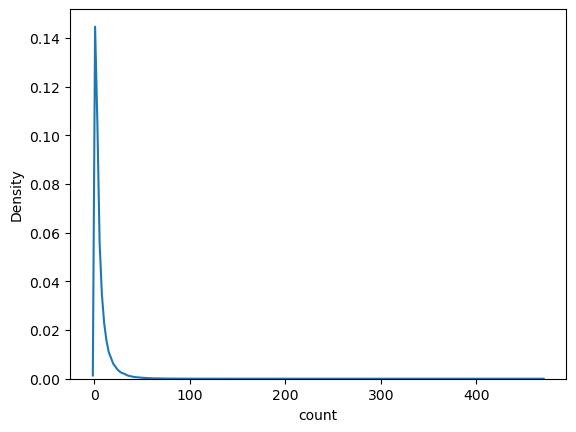

In [9]:
# How many unique events are mentioned in a single report?
vc = df["MentionIdentifier"].value_counts()
vc.describe()
_ = sns.kdeplot(vc)

# Preprocess Event Attributes

In [10]:
# Preview
events = events.set_index("GLOBALEVENTID", drop=True)  # Reindex
events.head()

,SQLDATE,FractionDate,EventTimeDate,QuadClass,CAMEOEventRoot,CAMEOEventBase,CAMEOEvent,GoldsteinScore,Actor1Code,Actor1CountryCode,...,Actor1Geo_Type,Actor1Geo_FullName,Actor2Code,Actor2CountryCode,Actor2KnownGroupCode,Actor2Type1Code,Actor2Name,Actor2Geo_Type,Actor2Geo_FullName,IsRootEvent
GLOBALEVENTID,,,,,,,,,,,,,,,,,,,,,
1078326026,20230101,2023.0027,20230101000000,1,04,043,043,2.8,NaN,NaN,...,0,NaN,COP,NaN,NaN,COP,POLICE OFFICER,0,NaN,1
1078326027,20230101,2023.0027,20230101000000,4,17,173,173,-5.0,NaN,NaN,...,0,NaN,COP,NaN,NaN,COP,DETECTIVE,0,NaN,1
1078326030,20230101,2023.0027,20230101000000,4,19,190,190,-10.0,NaN,NaN,...,0,NaN,COP,NaN,NaN,COP,DETECTIVE,0,NaN,1
1078326080,20230101,2023.0027,20230101000000,2,08,087,0874,10.0,NaN,NaN,...,0,NaN,RUS,RUS,NaN,NaN,MOSCOW,4,"Moscow, Moskva, Russia",1
1078326081,20230101,2023.0027,20230101000000,2,08,087,0874,10.0,NaN,NaN,...,0,NaN,RUS,RUS,NaN,NaN,MOSCOW,3,"Monroe County, Pennsylvania, United States",1


## Conflict

/var/folders/4l/jbwb4mc545x6m_zf23gyjhm00000gn/T/ipykernel_76846/1745875880.py:8: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  _ = sns.kdeplot(data=events.sort_values(group, ascending=True), x="GoldsteinScore", hue=group, fill=True, legend=False, ax=ax)
/var/folders/4l/jbwb4mc545x6m_zf23gyjhm00000gn/T/ipykernel_76846/1745875880.py:8: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  _ = sns.kdeplot(data=events.sort_values(group, ascending=True), x="GoldsteinScore", hue=group, fill=True, legend=False, ax=ax)
/var/folders/4l/jbwb4mc545x6m_zf23gyjhm00000gn/T/ipykernel_76846/1745875880.py:8: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  _ = sns.kdeplot(data=events.sort_values(group, ascending=True), x="GoldsteinScore", hue=group, fill=True, legend=False, ax=ax)
/var/folders/4l/jbw

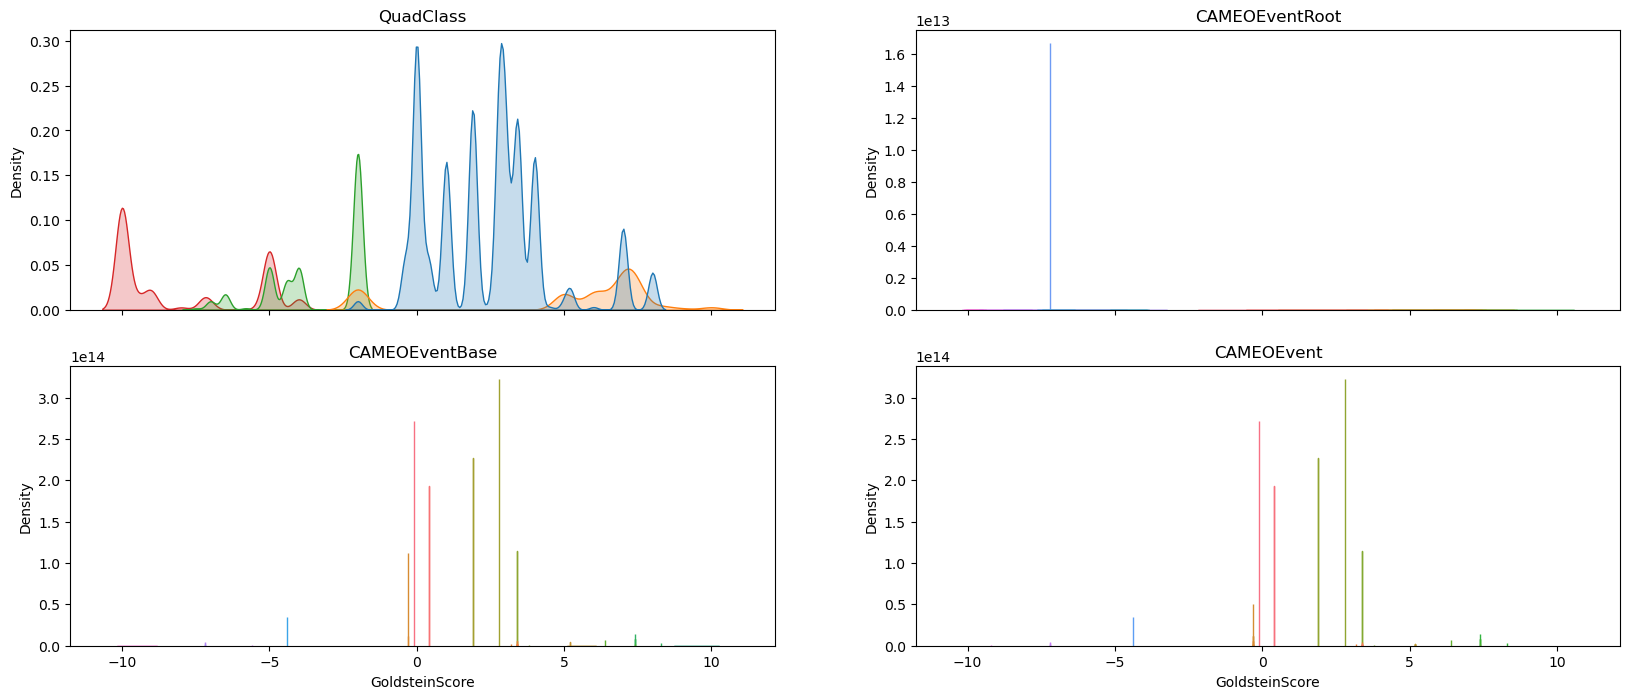

In [11]:
conflict_codes = ["QuadClass", "CAMEOEventRoot", "CAMEOEventBase", "CAMEOEvent"]
assert np.all(events[conflict_codes].isna().sum()==0)  # Ensure there are no nulls

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20,8), sharex=True)

for i, group in enumerate(conflict_codes):
    ax = axes[i//2, i%2]
    _ = sns.kdeplot(data=events.sort_values(group, ascending=True), x="GoldsteinScore", hue=group, fill=True, legend=False, ax=ax)
    _ = ax.set_title(group)

In [12]:
# Use rank correlation to identify conflict col that has the weakest association with  GoldsteinScore
# Consistent with visualization above, it's CAMEOEvent has the weakest and QuadClass has the strongest. Note that the differences between the 4 are actually minimal
from scipy.stats import spearmanr
alpha = 0.01
tmp = {}
for conflict_code in conflict_codes:
    p, frac = np.nan, 2**6/100
    while pd.isna(p) and (frac>=0.01):
        frac = frac / 2
        events_ = events.sample(frac=frac, random_state=seed)
        rho, p = spearmanr(events_[conflict_code], (events_["GoldsteinScore"]))
    tmp[conflict_code] = {"frac":frac, "rho":rho, "p":p, "stat_sig":p<alpha}
pd.DataFrame.from_dict(tmp, orient="index").sort_values("p", ascending=True)

,frac,rho,p,stat_sig
QuadClass,0.01,-0.583846,0.000000e+00,True
CAMEOEventRoot,0.01,-0.392469,0.000000e+00,True
CAMEOEventBase,0.01,-0.362731,6.998034e-273,True
CAMEOEvent,0.01,-0.362729,7.039958e-273,True


In [13]:
# Create list of selected event-based attributes
selected_event_attrs = ["GoldsteinScore", "CAMEOEvent"]
blocking_rule_attrs = ["QuadClass"]

## Event date 

In [14]:
# Preview date-relevant attributes
event_dates = ["SQLDATE", "FractionDate", "EventTimeDate"]
events[event_dates].head()

,SQLDATE,FractionDate,EventTimeDate
GLOBALEVENTID,,,
1078326026,20230101,2023.0027,20230101000000
1078326027,20230101,2023.0027,20230101000000
1078326030,20230101,2023.0027,20230101000000
1078326080,20230101,2023.0027,20230101000000
1078326081,20230101,2023.0027,20230101000000


In [15]:
# EventTimeDate is the most granular
# When does a story get old?
# Chakraborty et. al., 2021: 141.77 hours for NYTimes for highest lifetime impact
chakraborty_estimate = 141.77
np.round(chakraborty_estimate/24, 2)  # Equivalent to how many days?

5.91

In [16]:
# Inspect by datetime component
tmp = events["EventTimeDate"].astype(str).str.extract("(\d{4})(\d{2})(\d{2})(\d{2})(\d{2})(\d{2})").astype(int)
tmp.columns = ["Year", "Month", "Day", "Hour", "Minute", "Second"]
tmp.head()  # Preview
tmp.describe()

,Year,Month,Day,Hour,Minute,Second
GLOBALEVENTID,,,,,,
1078326026,2023,1,1,0,0,0
1078326027,2023,1,1,0,0,0
1078326030,2023,1,1,0,0,0
1078326080,2023,1,1,0,0,0
1078326081,2023,1,1,0,0,0


,Year,Month,Day,Hour,Minute,Second
count,883292.000000,883292.000000,883292.000000,883292.000000,883292.000000,883292.0
mean,2023.136063,6.245441,15.499288,9.220742,21.615004,0.0
std,0.342855,3.586027,8.705240,6.938399,16.876367,0.0
min,2023.000000,1.000000,1.000000,0.000000,0.000000,0.0
25%,2023.000000,3.000000,8.000000,3.000000,0.000000,0.0
50%,2023.000000,6.000000,15.000000,8.000000,15.000000,0.0
75%,2023.000000,10.000000,23.000000,16.000000,30.000000,0.0
max,2024.000000,12.000000,31.000000,23.000000,45.000000,0.0


<div class="alert alert-block alert-info">
    <ul>
        <li>Based on Chakraborty et. al. (2021) study, a news story has optimal balance between recency and relevance within 5.91 days.</li>
        <li>Among the datetime-relevant features from GDELT, EventDateTime is most granular and can be compared against Chakraborty et. al. estimate.</li>
        <li>EventDateTime is the most granular but the second attribute has no variance.</li>
        <li>Splink deduper supports this comparison between datetime objects based on their <a href="https://moj-analytical-services.github.io/splink/topic_guides/comparisons/customising_comparisons.html#date-comparison">documentation</a>.</li>
    </ul>
</div>

In [17]:
# Convert to datetime object
events["EventDateTime"] = pd.to_datetime(events["EventTimeDate"], format="%Y%m%d%H%M%S")
event_dates.append("EventDateTime")
event_attrs.append("EventDateTime")
events[event_dates].head()  # Preview

,SQLDATE,FractionDate,EventTimeDate,EventDateTime
GLOBALEVENTID,,,,
1078326026,20230101,2023.0027,20230101000000,2023-01-01
1078326027,20230101,2023.0027,20230101000000,2023-01-01
1078326030,20230101,2023.0027,20230101000000,2023-01-01
1078326080,20230101,2023.0027,20230101000000,2023-01-01
1078326081,20230101,2023.0027,20230101000000,2023-01-01


In [18]:
# Update list
selected_event_attrs.append("EventDateTime")
blocking_rule_attrs.append("SQLDATE")

## Actors

In [19]:
# Preview
actor_attrs = [attr for attr in event_attrs if attr[:5]=="Actor"]
events[actor_attrs].head()

,Actor1Code,Actor1CountryCode,Actor1KnownGroupCode,Actor1Type1Code,Actor1Name,Actor1Geo_Type,Actor1Geo_FullName,Actor2Code,Actor2CountryCode,Actor2KnownGroupCode,Actor2Type1Code,Actor2Name,Actor2Geo_Type,Actor2Geo_FullName
GLOBALEVENTID,,,,,,,,,,,,,,
1078326026,NaN,NaN,NaN,NaN,NaN,0,NaN,COP,NaN,NaN,COP,POLICE OFFICER,0,NaN
1078326027,NaN,NaN,NaN,NaN,NaN,0,NaN,COP,NaN,NaN,COP,DETECTIVE,0,NaN
1078326030,NaN,NaN,NaN,NaN,NaN,0,NaN,COP,NaN,NaN,COP,DETECTIVE,0,NaN
1078326080,NaN,NaN,NaN,NaN,NaN,0,NaN,RUS,RUS,NaN,NaN,MOSCOW,4,"Moscow, Moskva, Russia"
1078326081,NaN,NaN,NaN,NaN,NaN,0,NaN,RUS,RUS,NaN,NaN,MOSCOW,3,"Monroe County, Pennsylvania, United States"


In [20]:
# Describe
events_ = events.astype(str)[actor_attrs].replace("nan", np.nan)
tmp = events_.describe().T
tmp["maj_class_pct"] = tmp["freq"].div(tmp["count"])
tmp["sparsity"] = events_.isna().mean()

# View actors 1 and 2 separately
tmp[tmp.index.str[5]=="1"].sort_values("sparsity")
tmp[tmp.index.str[5]=="2"].sort_values("sparsity")

,count,unique,top,freq,maj_class_pct,sparsity
Actor1Geo_Type,883292,6,4,536758,0.607679,0.000000
Actor1Code,815179,2987,PHL,146679,0.179935,0.077113
Actor1Name,815179,3544,PHILIPPINE,127932,0.156937,0.077113
Actor1Geo_FullName,793444,9939,"Manila, Manila, Philippines",67497,0.085068,0.101719
Actor1CountryCode,555669,216,PHL,171683,0.308966,0.370911
Actor1Type1Code,352748,32,GOV,125266,0.355115,0.600644
Actor1KnownGroupCode,17033,42,UNO,6830,0.400986,0.980716


,count,unique,top,freq,maj_class_pct,sparsity
Actor2Geo_Type,883292,6,4,436126,0.493751,0.000000
Actor2Code,653903,2780,PHL,103660,0.158525,0.259698
Actor2Name,653903,3334,PHILIPPINE,95522,0.14608,0.259698
Actor2Geo_FullName,641556,9033,"Manila, Manila, Philippines",52056,0.08114,0.273676
Actor2CountryCode,449358,214,PHL,124974,0.278117,0.491269
Actor2Type1Code,283526,32,GOV,90453,0.319029,0.679012
Actor2KnownGroupCode,13999,39,UNO,5342,0.381599,0.984151


In [21]:
# Test for independence
from lib.utils.helper_functions import test_for_independence
# pairwise_comparison = lambda lst: sum([[(item, item_) for item_ in lst if item!=item_] for item in lst], [])
pairwise_comparison = lambda lst: sum([[(item, item_) for item_ in lst[i:] if item!=item_] for i, item in enumerate(lst)], [])
def get_pairwise_independence(df, features):
    comparisons = pairwise_comparison(features)
    results = {}
    for x, y in comparisons:
        series_x, series_y = df[x].fillna("__NULL__"), df[y].fillna("__NULL__")
        frac, p = 1, np.nan
        while pd.isna(p) & (frac<=0.01):
            frac = frac/2
            x_y_results = test_for_independence(series_x.sample(frac=frac, random_state=seed), series_y.sample(frac=frac, random_state=seed))
            p = x_y_results["p"]
        results[(x , y, frac)] = test_for_independence(series_x.sample(frac=frac, random_state=seed), series_y.sample(frac=frac, random_state=seed))
    return results

actor1_attrs = tmp[(tmp.index.str[5]=="1") & (tmp["sparsity"]<=0.5)].index.tolist()
pd.DataFrame.from_dict(get_pairwise_independence(events, actor1_attrs), orient="index").dropna().reset_index()

actor2_attrs = tmp[(tmp.index.str[5]=="2") & (tmp["sparsity"]<=0.5)].index.tolist()
pd.DataFrame.from_dict(get_pairwise_independence(events, actor2_attrs), orient="index").dropna().reset_index()

/Users/user/miniforge3/envs/quick/lib/python3.8/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


,level_0,level_1,level_2,Test,Statistic,P-value
0,Actor1Code,Actor1CountryCode,1,CHI SQUARED,97736.818515,0.0
1,Actor1Code,Actor1Name,1,CHI SQUARED,0.000000,1.0
2,Actor1Code,Actor1Geo_FullName,1,CHI SQUARED,0.000000,1.0
3,Actor1CountryCode,Actor1Name,1,CHI SQUARED,0.000000,1.0
4,Actor1CountryCode,Actor1Geo_FullName,1,CHI SQUARED,0.000000,1.0
5,Actor1Name,Actor1Geo_FullName,1,CHI SQUARED,0.000000,1.0


,level_0,level_1,level_2,Test,Statistic,P-value
0,Actor2Code,Actor2CountryCode,1,CHI SQUARED,18993.879553,0.0
1,Actor2Code,Actor2Name,1,CHI SQUARED,0.000000,1.0
2,Actor2Code,Actor2Geo_FullName,1,CHI SQUARED,0.000000,1.0
3,Actor2CountryCode,Actor2Name,1,CHI SQUARED,0.000000,1.0
4,Actor2CountryCode,Actor2Geo_FullName,1,CHI SQUARED,0.000000,1.0
5,Actor2Name,Actor2Geo_FullName,1,CHI SQUARED,0.000000,1.0


In [22]:
# Update list
selected_event_actor_attrs = ["Actor1Code", "Actor1Name", "Actor1Geo_FullName", "Actor2Code", "Actor2Name", "Actor2Geo_FullName"]
selected_event_attrs.extend(selected_event_actor_attrs)
blocking_rule_attrs.extend(["Actor1CountryCode", "Actor2CountryCode"])

In [23]:
# Check for most common combinations
events[selected_event_actor_attrs].fillna("__NULL__").value_counts(normalize=True).head(20).reset_index()

,Actor1Code,Actor1Name,Actor1Geo_FullName,Actor2Code,Actor2Name,Actor2Geo_FullName,proportion
0,PHL,PHILIPPINE,"Philippine, Benguet, Philippines",__NULL__,__NULL__,__NULL__,0.005875
1,PHL,PHILIPPINE,"Manila, Manila, Philippines",__NULL__,__NULL__,__NULL__,0.005671
2,PHL,MANILA,"Manila, Manila, Philippines",__NULL__,__NULL__,__NULL__,0.002471
3,PHL,PHILIPPINE,Philippines,__NULL__,__NULL__,__NULL__,0.002218
4,__NULL__,__NULL__,__NULL__,PHL,PHILIPPINE,"Philippine, Benguet, Philippines",0.001888
5,__NULL__,__NULL__,__NULL__,PHL,PHILIPPINE,"Manila, Manila, Philippines",0.001800
6,ISR,ISRAEL,"Gaza, Israel (general), Israel",__NULL__,__NULL__,__NULL__,0.001796
7,CHN,CHINA,"Beijing, Beijing, China",__NULL__,__NULL__,__NULL__,0.001767
8,CHN,CHINA,China,__NULL__,__NULL__,__NULL__,0.001323
9,PHL,PHILIPPINE,"Malaca, Pangasinan, Philippines",__NULL__,__NULL__,__NULL__,0.001083


In [24]:
# Store in separate df
events_bu = events.copy()  # Back up original dataframe
events = events[blocking_rule_attrs + selected_event_attrs]#.fillna("__NULL__")
events.head(10)

,QuadClass,SQLDATE,Actor1CountryCode,Actor2CountryCode,GoldsteinScore,CAMEOEvent,EventDateTime,Actor1Code,Actor1Name,Actor1Geo_FullName,Actor2Code,Actor2Name,Actor2Geo_FullName
GLOBALEVENTID,,,,,,,,,,,,,
1078326026,1,20230101,NaN,NaN,2.8,043,2023-01-01,NaN,NaN,NaN,COP,POLICE OFFICER,NaN
1078326027,4,20230101,NaN,NaN,-5.0,173,2023-01-01,NaN,NaN,NaN,COP,DETECTIVE,NaN
1078326030,4,20230101,NaN,NaN,-10.0,190,2023-01-01,NaN,NaN,NaN,COP,DETECTIVE,NaN
1078326080,2,20230101,NaN,RUS,10.0,0874,2023-01-01,NaN,NaN,NaN,RUS,MOSCOW,"Moscow, Moskva, Russia"
1078326081,2,20230101,NaN,RUS,10.0,0874,2023-01-01,NaN,NaN,NaN,RUS,MOSCOW,"Monroe County, Pennsylvania, United States"
1078326209,1,20230101,CHN,NaN,7.0,046,2023-01-01,CHN,CHINA,"Beijing, Beijing, China",NaN,NaN,NaN
1078326246,1,20230101,NaN,NaN,1.9,042,2023-01-01,COP,POLICE OFFICER,NaN,NaN,NaN,NaN
1078326357,2,20230101,NaN,NaN,6.0,060,2023-01-01,EDUCOP,UNIVERSITY,"Moscow, Moskva, Russia",GOV,AUTHORITIES,"Moscow, Moskva, Russia"
1078326359,2,20230101,NaN,NaN,-2.0,090,2023-01-01,EDUCOP,UNIVERSITY,"Moscow, Moskva, Russia",GOV,AUTHORITIES,"Moscow, Moskva, Russia"


In [25]:
# Export
events.to_parquet("cleaned_events.parquet", compression="gzip")

# Preprocess Reporting Features

In [ ]:
docs[""]

In [ ]:
event_report_map.merge(events, left_on="GLOBALEVENTID",right_index=True)

In [ ]:
events[reporting_attrs]

## Based on previous EDA

In [ ]:
# Load scraped data
scraped = pd.read_csv("scraped_79639.csv", index_col="Unnamed: 0")
scraped.shape

In [ ]:
# Extract outlet
scraped["DocOutlet"] = scraped.index.str.upper().map(extract_host)
scraped["DocOutlet"].value_counts(normalize=True, dropna=False)

In [ ]:
# Exclude CNN and PHILIPPINETIMES-- unable to scrape
scraped = scraped[~scraped["DocOutlet"].isin(["CNNPHILIPPINES", "PHILIPPINETIMES"])]
scraped.shape

In [ ]:
# Replace empty lists with nan
scraped.loc[scraped.query("DocAuthors=='[]'").index, "DocAuthors"] = np.nan
scraped.loc[scraped.query("DocKeywords=='[]'").index, "DocKeywords"] = np.nan

In [ ]:
# Check sparsity
tmp = scraped.groupby("DocOutlet")[["DocAuthors", "DocPubDate", "DocText", "DocKeywords"]].agg(lambda ser: ser.isna().mean())
_ = sns.heatmap(tmp, annot=True, cbar=False)

### Clean RAPPLER DocText

In [ ]:
# Find pattern
scraped[scraped["DocOutlet"]=="RAPPLER"]["DocText"].str[:107].value_counts()[:10]

In [ ]:
# Clean doctext using pattern
pat = scraped[scraped["DocOutlet"]=="RAPPLER"]["DocText"].str[:107].value_counts().index[0]
scraped.loc[scraped.query("DocOutlet=='RAPPLER'").index, "DocText"] = scraped.loc[scraped.query("DocOutlet=='RAPPLER'").index, "DocText"].str.replace(pat, "")
scraped[scraped["DocOutlet"]=="RAPPLER"]["DocText"].str[:107].value_counts()[:10]  # Confim changes

## DocAuthors

In [ ]:
n = 2**4
samples = [scraped[scraped["DocOutlet"]==group].sample(n=n, random_state=seed) for group in scraped["DocOutlet"].unique()]

In [ ]:
# Check samples from each outlet
feature = "DocAuthors"
[display(sample[["DocOutlet", feature]]) for sample in samples]

In [ ]:
# Check common author items
scraped["DocAuthors"].dropna().apply(eval).explode().value_counts().head(30).index.tolist()

In [ ]:
# Remove non-meaningful ones
blacklisted_authors = [
    "Var Molongui_Authorship_Byline_Params",
    "Byline_Suffix",
    "Byline_Prefix",
    "Byline_Separator",
    "Byline_Last_Separator",
    "Byline_Link_Title",
    "View All Posts By",
    "Byline_Link_Class",
    "Byline_Dom_Tree",
    "Byline_Dom_Prepend",
    "If Storyparsed.Issaf",
    "Storyparsed.Author_Details.Parsed_Byline",
    "If Storyparsed.Author_Details.Author_Twitter",
    "Storyparsed.Storyobj.Brand.Brand_Name",
    "Compare Storyparsed.Author_Details.Parsed_Byline",
    "Or",
    "If",
    "If Storyparsed.Author_Details.Author_Facebook",
    "If Storyparsed.Author_Details.Photo_Filename",
    "If Storyparsed.Storyobj.Brand",  # Found in separate exploration
]

In [ ]:
# Create col with list of valid authors
query = f'{feature}.isnull()==False'
scraped.loc[scraped.query(query).index, "DocAuthorsLst"] = scraped.loc[scraped.query(query).index, "DocAuthors"].apply(lambda lst: [item for item in eval(lst) if item not in blacklisted_authors])

query = f'{feature}.isnull()'
scraped.loc[scraped.query(query).index, "DocAuthorsLst"] = scraped.loc[scraped.query(query).index, "DocAuthorsLst"].fillna("").apply(list)
scraped[f"{feature}Len"] = scraped[f"{feature}Lst"].apply(len)

scraped[f"{feature}Lst"].explode().value_counts()[:20]  # Check updated frequent authors

In [ ]:
# Check for instances of "THE" prefix
scraped[f"{feature}Lst"].explode().dropna()[scraped[f"{feature}Lst"].explode().dropna().str.contains("^THE", regex=True, flags=re.I)].value_counts()[:20]

In [ ]:
# Mask "the" prefixes
scraped[f"{feature}Lst"] = scraped[f"{feature}Lst"].apply(lambda lst: [re.sub("^THE\s", "", item, flags=re.I)  for item in lst])
scraped[f"{feature}Lst"].explode().value_counts()[:20]    # Check updated frequent authors

### RAPPLER

In [ ]:
# Check numbers of writers in Rappler articles
pd.DataFrame(
    {
        "pct":scraped[scraped["DocOutlet"]=="RAPPLER"]["DocAuthorsLst"].apply(len).value_counts(normalize=True).sort_index(), 
        "cum_pct":scraped[scraped["DocOutlet"]=="RAPPLER"]["DocAuthorsLst"].apply(len).value_counts(normalize=True).sort_index().cumsum()
    }
)

In [ ]:
# Samples of popular non-single writer records
mask = (scraped["DocOutlet"]=="RAPPLER") & (scraped[f"{feature}Len"]>1)
scraped[mask]["DocAuthors"].value_counts()[:20]

<div class="alert alert-block alert-info">
    When author is more than 1, the other items can be<ul>
        <li>A description of author (ie: 'Jairo Bolledo', 'Jairo Bolledo Is A Multimedia Reporter At Rappler Covering Justice')</li>
        <li>A variation of main name (ie: 'Paterno Esmaquel Ii', 'Paterno R. Esmaquel Ii'; 'Herbie G', 'Herbie Gomez')</li>
        <li>A topic (ie: 'Covering Macroeconomy')</li>
    </ul>
</div>

In [ ]:
# We know "Joann Manabat - Cms" and "Joann Manabat" is the same
assert scraped["DocAuthorsLst"].explode().dropna().drop_duplicates().str.upper().str.contains("CMS").sum() == 1  # This author is the only onew using this suffix
assert scraped["DocAuthorsLst"].apply(lambda lst: ("Joann Manabat - Cms" in lst) & ("Joann Manabat" not in lst)).sum() == 0  # Her works always have both name variations

In [ ]:
# Other names that can be deduplicated
scraped["DocAuthorsLst"].apply(lambda lst: ("Herbie G" in lst) & ("Herbie Gomez" not in lst)).sum()
scraped["DocAuthorsLst"].apply(lambda lst: ("Angelo Gonzales" in lst) & ("Gelo Gonzales" not in lst)).sum()
scraped["DocAuthorsLst"].apply(lambda lst: ("Paterno Esmaquel Ii" in lst) & ("Paterno R. Esmaquel Ii" not in lst)).sum()

In [ ]:
# Which names variants are used more often?
dup_names = [
    "Herbie G", "Herbie Gomez", 
    "Angelo Gonzales", "Gelo Gonzales", 
    "Paterno Esmaquel Ii", "Paterno R. Esmaquel Ii", 
]
scraped["DocAuthorsLst"].explode().dropna().value_counts().loc[dup_names]

In [ ]:
# Deduplicate names, prioritizing most used name variants
dup_name_map = {
    "Herbie Gomez" : "Herbie G", 
    "Gelo Gonzales" : "Angelo Gonzales", 
    "Paterno R. Esmaquel Ii" : "Paterno Esmaquel Ii", 
    "Joann Manabat - Cms" : "Joann Manabat", 
}
scraped["DocAuthorsLst"] = scraped["DocAuthorsLst"].apply(lambda lst: [item if item not in list(dup_name_map.keys()) else dup_name_map[item] for item in lst])

# Deduplicate lists
def deduplicate_list(lst):
    dedup_list = []
    for item in lst:
        if item not in dedup_list:
            dedup_list.append(item)
    return dedup_list

scraped["DocAuthorsLst"] = scraped["DocAuthorsLst"].apply(deduplicate_list)
scraped["DocAuthorsLen"] = scraped["DocAuthorsLst"].apply(len)

In [ ]:
# Confirm changes
assert scraped["DocAuthorsLst"].apply(lambda lst: ("Herbie G" in lst) & ("Herbie Gomez" in lst)).sum() == 0
assert scraped["DocAuthorsLst"].apply(lambda lst: ("Angelo Gonzales" in lst) & ("Gelo Gonzales" in lst)).sum() == 0
assert scraped["DocAuthorsLst"].apply(lambda lst: ("Paterno Esmaquel Ii" in lst) & ("Paterno R. Esmaquel Ii" in lst)).sum() == 0
assert scraped["DocAuthorsLst"].apply(lambda lst: ("Joann Manabat - Cms" in lst) & ("Joann Manabat" in lst)).sum() == 0

In [ ]:
# Get list of valid authors
# Assumption: Only those that appear first at least one is valid
rappler_authors = scraped.query('(DocOutlet=="RAPPLER") & (DocAuthorsLen>0)')[f"{feature}Lst"].apply(lambda lst: lst[0]).value_counts().index.tolist()
rappler_authors.remove('Gabaizas Is A Digital Forensics Researcher At Rappler. She First Joined Rappler Straight Out Of College As A Digital Communications Specialist. She Hopes People Learn To Read Past Headlines The Same Way She Hopes Punk Never Dies.')
len(rappler_authors)

In [ ]:
# Clean values
query = '(DocOutlet=="RAPPLER") & (DocAuthorsLen>0)'
scraped.loc[scraped.query(query).index, f"{feature}Lst"] = scraped.loc[scraped.query(query).index, f"{feature}Lst"].apply(lambda lst: [item for item in lst if item in rappler_authors])
scraped.loc[scraped.query(query).index, f"{feature}Lst"].explode().value_counts()[:10]

import spacy
import en_core_web_sm
from functools import partial

nlp = en_core_web_sm.load()
def get_pos_tags(string):
    doc = nlp(string)
    return [(token.text, token.pos_) for token in doc]

def get_pos_pct(string, pos):
    pos_tags = get_pos_tags(string)
    return len([(token, pos_) for (token, pos_) in pos_tags if pos_==pos]) / len(pos_tags)
get_propn_pct = partial(get_pos_pct, pos="PROPN")

### GMANETWORK

In [ ]:
query = f'(DocOutlet=="GMANETWORK") & ({feature}Len>0)'
scraped.query(query)[f"{feature}Lst"].explode().value_counts()[:10]
tmp = scraped.query('DocOutlet=="GMANETWORK"')[f"{feature}Lst"].explode().dropna().drop_duplicates()
tmp[tmp.str.contains("\swith\s", flags=re.I)]

In [ ]:
# Handle with keywords
tmp = scraped.query('DocOutlet=="GMANETWORK"')[f"{feature}Lst"].explode().dropna().drop_duplicates()
tmp[tmp.str.contains("\swith\s", flags=re.I)]
def handle_with_authorship(authors):
    lst = []
    for author in authors:
        if " With " in author:
            lst.extend(author.split(" With "))
        else:
            lst.append(author)
    return lst

scraped[f"{feature}Lst"] = scraped[f"{feature}Lst"].apply(handle_with_authorship)
scraped[f"{feature}Len"] = scraped[f"{feature}Lst"].apply(len)

### BUSINESSMIRROR

In [ ]:
# No fix needed after blacklisting non-author entries
query = f'(DocOutlet=="BUSINESSMIRROR") & ({feature}Len>0)'
scraped.query(query)[f"{feature}Lst"].explode().value_counts()[:10]

### NORMALIZATION

In [ ]:
# Capitalize
scraped[f"{feature}Lst"] = scraped[f"{feature}Lst"].apply(lambda lst: [item.upper() for item in lst])
scraped[f"{feature}Len"] = scraped[f"{feature}Lst"].apply(len)

In [ ]:
samples = [scraped[scraped["DocOutlet"]==group].sample(n=n, random_state=seed) for group in scraped["DocOutlet"].unique()]
[display(sample[["DocOutlet", f"{feature}Lst"]]) for sample in samples]

In [ ]:
# Make entries with 0 authors after cleaning nan
query = f'{feature}Len==0'
scraped.loc[scraped.query(query).index, feature].isna().sum()
scraped.loc[scraped.query(query).index, feature] = np.nan
scraped.loc[scraped.query(query).index, feature].isna().sum()

In [ ]:
# Check for sparsity by outlet
scraped.groupby("DocOutlet")[feature].apply(lambda ser: ser.isna().mean())

## DocText

In [ ]:
# Extract deck headline
scraped["DocDeckHeadline"] = scraped["DocText"].str.extract("(^[\s\dA-Z]*)\.", expand=False)
scraped.groupby("DocOutlet")["DocDeckHeadline"].apply(lambda ser: ser.isna().mean())
scraped["DocDeckHeadline"].dropna().drop_duplicates()[:10]  # Samples

In [ ]:
# Drop because only rappler uses it frequently
scraped = scraped.drop(columns=["DocDeckHeadline"], axis=1)

## DocKeywords

In [ ]:
# Normalize entries
feature = "DocKeywords"
query = f'{feature}.isnull()'
scraped.loc[scraped.query(query).index, f"{feature}Lst"] = scraped.loc[scraped.query(query).index, feature].fillna("").apply(list)

query = f'{feature}.isnull()==False'
scraped.loc[scraped.query(query).index, f"{feature}Lst"] = scraped.query(query)[feature].apply(eval).apply(lambda lst: [item.upper() for item in lst])

scraped[f"{feature}Len"] = scraped[f"{feature}Lst"].apply(len)

scraped.head()  # Preview

## DocPubDate

In [ ]:
feature = "DocPubDate"
n = 10

samples = [scraped[scraped["DocOutlet"]==group].sample(n=n, random_state=seed) for group in scraped["DocOutlet"].unique()]
[display(sample[["DocOutlet", feature]]) for sample in samples]

In [ ]:
scraped[feature].str.contains(r"\+\d{2}:\d{2}$", na=False, regex=True)

In [ ]:
# Normalize dates
query = f'{feature}.str.contains("\\+\\d{{2}}:\\d{{2}}$", na=False, regex=True)'
scraped.loc[scraped.query(query).index, f"{feature}Norm"] = pd.to_datetime(scraped.loc[scraped.query(query).index, feature], utc=True).astype(str).str[:-6]

query = f'{feature}.str.contains("\\+\\d{{2}}:\\d{{2}}$", na=False, regex=True)==False'
scraped.loc[scraped.query(query).index, f"{feature}Norm"]  = pd.to_datetime(scraped.loc[scraped.query(query).index, feature])

scraped[f"{feature}Norm"] = pd.to_datetime(scraped[f"{feature}Norm"])
scraped[f"{feature}Norm"].dropna().describe()

In [ ]:
# Expected min date is Jan 1 2023, check those before expected but ignore for now
(scraped[f"{feature}Norm"] < pd.to_datetime("2023-01-01")).sum()
scraped[scraped[f"{feature}Norm"] < pd.to_datetime("2023-01-01")]

## DocHeadline

In [ ]:
# Extract and normalize headline
scraped["DocHeadline"] = scraped.index.map(extract_headline).str.upper()

# Checks

In [ ]:
# Preview
scraped.head(10)

In [ ]:
# Reorder columns
scraped = scraped[["DocOutlet", "DocAuthors", "DocAuthorsLst", "DocAuthorsLen", "DocPubDate", "DocPubDateNorm", "DocHeadline", "DocText", "DocKeywords", "DocKeywordsLst", "DocKeywordsLen"]]

In [ ]:
nlp("Hello")

In [ ]:
# Export
scraped.to_parquet("cleaned_docs.parquet", index=True, compression="gzip")